# TRT KPI: Minimize Time to Science
### IN PROGRESS: Updated in PI 22.2 (Spring 2022) 

The following KPIs are measured in this notebook:

* Number of lines of code for a given workflow in the cloud / Number of lines for same workflow on-prem
* Run time for a given workflow in the cloud / run time for same workflow on-prem

#### Workflows: 
* Basic data search, customize, access, plotting, with a collection that is available on-prem and in Earthdata Cloud.

* Data tested (updated in PI 22.2):
    * Using Cloud Metrics to select popular service combination:
        * Synchronous, L2SS, NetCDF, Spatial & variable request
            * Can we filter by non-admin and by collection requested?
    * Working off of [Openscapes OPeNDAP tutorial](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/06_S6_OPeNDAP_Access_Gridding.html)
    * Switching from UAT to PROD examples

```
ShortName = 'JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F'
concept_id = 'C1968980576-POCLOUD'
```

* On Prem subsetting:
    * [PO.DAAC python script: Subset L1/L2 using OPeNDAP](https://podaac-tools.jpl.nasa.gov/drive/files/common/sw/subsetting/subset_dataset_l2.py)

## Import Packages

In [10]:

#cloud workflow
import requests
from pprint import pprint
from harmony import BBox, Client, Collection, Request, LinkType
from harmony.config import Environment
import datetime as dt
from pystac import Catalog
from pystac_client import Client
import s3fs
import xarray as xr

## On-prem Workflow

## Cloud Workflow

### 1. Determine subsetting service options

#### Steps Involved (NEED TO UPDATE):

* Add step to identify collection of interest

```
Here we are jumping ahead and already know the `concept_id` we are interested in, by browsing cloud-hosted datasets from PO.DAAC in Earthdata Search: https://search.earthdata.nasa.gov/portal/podaac-cloud/search. 

((Non-Code) Determine precise data product short name (perhaps already known by users)
1. Set data product short name in code)

(##### Alternative for 12-17

10. (Non-Code) Go to Earthdata Search
1. (Non-Code) Search for data product short name or similar
1. (Non-Code) Select correct collection, revealing CMR Concept ID
1. Copy/paste the CMR Concept ID into code)

We are going to focus on `MODIS_A-JPL-L2P-v2019.0`: GHRSST Level 2P Global Sea Surface Skin Temperature from the Moderate Resolution Imaging Spectroradiometer (MODIS) on the NASA Aqua satellite (GDS2). Let's first save this as a variable that we can use later on once we request data from Harmony.

We will view the top-level metadata for this collection to see what additional service and variable metadata exist.

We need to isolate the services returned for this dataset:

Inspect the first service returned. Now we're going to search the services endpoint to view that individual service's metadata, like we did with our dataset above. This time, we're explicitly setting the format of the response to umm-json in the Accept Header in order to see detailed metadata about the service.

```

1. Set the token as a request parameter
1. Set desired CMR output format for collections (using the default requires more steps to get at the desired information)
1. Perform CMR collection search using the collection-related search fields
1. Parse the search result
1. Retrieve collection from the search result
1. Retrieve associated service IDs from the collection
1. Set desired (different) output format for services
1. Format a query to fetch the service for each service ID (why isn't this a link relation?)
1. Perform CMR service search for each each service ID
1. Parse the search result
1. Retrieve service from the search result
1. Retrieve associated service options from the service


In [3]:
%time 

url = 'https://cmr.earthdata.nasa.gov/search'
collection_url = f'{url}/{"collections"}'

short_name= 'MODIS_A-JPL-L2P-v2019.0'
concept_id = 'C1940473819-POCLOUD'

response = requests.get(collection_url, 
                        params={
                            'concept_id': concept_id,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()
# pprint(response)

services = response['feed']['entry'][0]['associations']['services']
print(services)

service_url = "https://cmr.earthdata.nasa.gov/search/services"

service_response = requests.get(service_url, 
                        params={
                            'concept_id': services[0],
                            },
                        headers={
                            'Accept': 'application/vnd.nasa.cmr.umm_results+json'
                            }
                       )
service_response = service_response.json()
pprint(service_response)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
['S1962070864-POCLOUD', 'S2004184019-POCLOUD', 'S2153799015-POCLOUD', 'S2227193226-POCLOUD']
{'hits': 1,
 'items': [{'meta': {'concept-id': 'S1962070864-POCLOUD',
                     'concept-type': 'service',
                     'deleted': False,
                     'format': 'application/vnd.nasa.cmr.umm+json',
                     'native-id': 'POCLOUD_podaac_l2_cloud_subsetter',
                     'provider-id': 'POCLOUD',
                     'revision-date': '2022-05-31T23:46:37.054Z',
                     'revision-id': 25,
                     'user-id': 'chen5510'},
            'umm': {'AccessConstraints': 'None',
                    'Description': 'Endpoint for subsetting L2 Subsetter via '
                                   'Harmony',
                    'LongName': 'PODAAC Level 2 Cloud Subsetter',
                    'MetadataSpecification': {'Name': 'UMM-S',
                                              

### 2. Determine variables for collection of interest

#### Steps Involved (NEED TO UPDATE):

```
Several variable records are returned. Again, like we did for services, we'll search the variables endpoint to view an individual variable's metadata, and we'll print out the list of variables for our dataset. 

Next, print out a simple list of all associated variable names by looping the same variable response we submitted above, this time for each variable:
```

34. Retrieve associated variable IDs from the collection
1. Set desired (different) output format for variables
1. Format a query to fetch the service for each variable ID (why isn't this a link relation?)
1. Perform CMR variable search for each variable ID
1. Parse the search result
1. Retrieve variable from the search result
1. Retrieve variable names from the variable

##### Notes
* Assumes we could reuse the already-searched and parsed collection record from service lookup step with refactoring


In [4]:
%time 

variables = response['feed']['entry'][0]['associations']['variables']
print(variables)

var_url = "https://cmr.earthdata.nasa.gov/search/variables"
var_response = requests.get(var_url, 
                        params={
                            'concept_id': variables[0],
                            },
                        headers={
                            'Accept': 'application/vnd.nasa.cmr.umm_results+json'
                            }
                       )
var_response = var_response.json()
#pprint(var_response)

var_list = []
for i in range(len(variables)):
    var_response = requests.get(var_url, 
                            params={
                                'concept_id': variables[i],
                                },
                            headers={
                                'Accept': 'application/vnd.nasa.cmr.umm_results+json'
                                }
                           )
    var_response = var_response.json()
    var_list.append(var_response['items'][0]['umm']['Name'])

pprint(var_list)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.53 µs
['V1997812737-POCLOUD', 'V1997812697-POCLOUD', 'V2112014688-POCLOUD', 'V1997812756-POCLOUD', 'V1997812688-POCLOUD', 'V1997812670-POCLOUD', 'V1997812724-POCLOUD', 'V2112014684-POCLOUD', 'V1997812701-POCLOUD', 'V1997812681-POCLOUD', 'V2112014686-POCLOUD', 'V1997812663-POCLOUD', 'V1997812676-POCLOUD', 'V1997812744-POCLOUD', 'V1997812714-POCLOUD']
['sses_standard_deviation_4um',
 'l2p_flags',
 'time',
 'dt_analysis',
 'sses_standard_deviation',
 'sst_dtime',
 'sses_bias_4um',
 'lat',
 'sea_surface_temperature_4um',
 'sses_bias',
 'lon',
 'sea_surface_temperature',
 'quality_level',
 'wind_speed',
 'quality_level_4um']


### 3. Request variable subset


#### Steps Involved (NEED TO UPDATE):

'''
We can check on the progress of a processing job with status(). This method blocks while communicating with the server but returns quickly.

Depending on the size of the request, it may be helpful to wait until the request has completed processing before the remainder of the code is executed. The wait_for_processing() method will block subsequent lines of code while optionally showing a progress bar.
'''

41. Create Harmony client with previously obtained auth (or set up / use .netrc)
1. Construct Harmony request object using desired spatial / temporal / variables
1. Submit the Harmony request, obtaining a Job ID

### 2. Declare time and bounding box search parameters

_Using a bounding box that will cover granules supported in on-prem OPeNDAP and L2SS_

In [5]:
%time

from harmony import BBox, Client, Collection, Request, LinkType

harmony_client = Client()

request = Request(
    collection=Collection(id=short_name),
    spatial=BBox(-97.77667,21.20806,-83.05197,30.16605),
    temporal={
        'start': dt.datetime(2021, 8, 20),
        'stop': dt.datetime(2021, 8, 21),
    },
)

job_id = harmony_client.submit(request)
print(job_id)

harmony_client.status(job_id)

harmony_client.wait_for_processing(job_id, show_progress=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
344da0d9-fb81-47ba-bcee-202e52467fa8


 [ Processing: 100% ] |###################################################| [|]


### 4. Retrieve AWS Credentials

#### Steps Involved (NEED TO UPDATE):

44. Obtain AWS Credentials for in-region use

In [7]:
%time

creds = harmony_client.aws_credentials()
# print(creds)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


### 5. Read in Data using xarray

#### Steps Involved (NEED TO UPDATE):

45. Retrieve s3 URLs returned from Harmony
1. Create a file system using `s3fs` in order to read into `xarray`
1. Open the file system using h5py
1. Create xarray dataset from selected variables of interest in h5py object

In [11]:
%time

results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)
pprint(urls)

s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

f = s3_fs.open(urls[1], mode='rb')
ds = xr.open_dataset(f)
ds

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
['s3://harmony-prod-staging/public/podaac/l2-subsetter/8289859e-a4a7-4a3e-bbee-8758ec5462f5/20210820203501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/8289859e-a4a7-4a3e-bbee-8758ec5462f5/20210820190001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/8289859e-a4a7-4a3e-bbee-8758ec5462f5/20210820185501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/8289859e-a4a7-4a3e-bbee-8758ec5462f5/20210820093501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/8289859e-a4a7-4a3e-bbee-8758ec5462f5/20210820080001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/8289859e-a4a7-4a3e-bbee-8758ec5462f5/202108200

<xarray.Dataset>
Dimensions:                  (nj: 543, ni: 948, time: 1)
Coordinates:
    lat                      (nj, ni, time) float32 ...
    lon                      (nj, ni, time) float32 ...
  * time                     (time) datetime64[ns] 2021-08-20T19:00:01
Dimensions without coordinates: nj, ni
Data variables:
    sea_surface_temperature  (time, nj, ni) float32 ...
    sst_dtime                (time, nj, ni) timedelta64[ns] ...
    quality_level            (time, nj, ni) float32 ...
    sses_bias                (time, nj, ni) float32 ...
    sses_standard_deviation  (time, nj, ni) float32 ...
    l2p_flags                (time, nj, ni) int16 ...
    chlorophyll_a            (time, nj, ni) float32 ...
    K_490                    (time, nj, ni) float32 ...
    wind_speed               (time, nj, ni) float32 ...
    dt_analysis              (time, nj, ni) float32 ...
Attributes: (12/50)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Aqua L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC\n2022-06-13 ...
    ...                         ...
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Ascending
    endDirection:               Ascending
    day_night_flag:             Day
    history_json:               [{"date_time": "2022-06-13T21:00:01.055953+00...

### 9. Plot data in place

#### Steps Involved:

49. Plot each variable (collapsed as incomplete, use-case-specific, and generally just necessary)

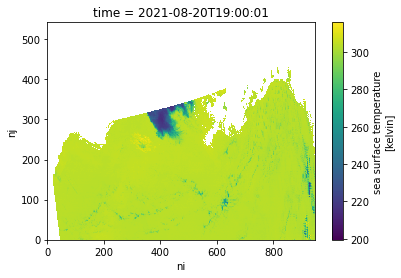

In [12]:
ds.sea_surface_temperature.plot() ;

## STAC workflow (in progress)

In [ ]:
# stac_catalog_url = harmony_client.stac_catalog_url(job_id)
# stac_catalog_url

# cat = Client.open(stac_catalog_url)

# print(cat.title)
# s3_links = []
# for item in cat.get_all_items():
#     print(item.datetime, [asset.href for asset in item.assets.values()])
#     s3_links.append([asset.href for asset in item.assets.values()])

# import rich.table

# table = rich.table.Table("Asset Key", "Descripiption")
# for asset_key, asset in selected_item.assets.items():
#     # print(f"{asset_key:<25} - {asset.title}")
#     table.add_row(asset_key, asset.title)

# table